In [1]:
import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sktime.datasets import load_arrow_head  # univariate dataset
from sktime.datasets.base import load_japanese_vowels  # multivariate dataset
from sktime.transformers.series_as_features.rocket import Rocket
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd

import os

print('OK !')

In /Users/thanatchonchongmankhong/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/thanatchonchongmankhong/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/thanatchonchongmankhong/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/thanatchonchongmankhong/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotli

OK !


In [2]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 

print('OK !')

OK !


## Let's start by downloading the data: 

Please download data zip from

[DOWNLOAD HERE](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip)

Then unzip it and put 'UCI HAR Dataset' folder into 'data' directory.

In [3]:
DATA_PATH = "data/"
TRAIN = "train/"
TEST = "test/"
DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


print('OK !')

OK !


## Preparing dataset:

In [4]:
def preprocess_data(data_array):

    dim_dict = {}

    for i in range(9):
        name_i = f'dim_{str(i)}'
        dim_dict[name_i] = []

    for i in range(data_array.shape[0]):
        for j in range(data_array.shape[1]):
            name_dim = f'dim_{str(j)}'
            dim_dict[name_dim].append(pd.Series(data_array[i][j]).astype('float64'))
            
    return pd.DataFrame(dim_dict)

print('OK !')

OK !


In [5]:
X_train = X_train.reshape(-1,9,128)
X_test = X_test.reshape(-1,9,128)

%time X_train = preprocess_data(X_train)
%time X_test = preprocess_data(X_test)

y_train = list(y_train.copy().ravel())
y_test = list(y_test.copy().ravel())

y_train = [str(each) for each in y_train]
y_test = [str(each) for each in y_test]


CPU times: user 16.9 s, sys: 177 ms, total: 17.1 s
Wall time: 17 s
CPU times: user 8.7 s, sys: 144 ms, total: 8.84 s
Wall time: 9.98 s


## Let's build the model using Rocket:

In [6]:
rocket_pipeline = make_pipeline(
    Rocket(num_kernels = 10000, random_state = 1),
    RidgeClassifierCV(alphas=np.logspace(-3, 3, 10), normalize=True)
#     LogisticRegression(random_state=0)
)

%time rocket_pipeline.fit(X_train, y_train)

CPU times: user 15min 20s, sys: 11.5 s, total: 15min 32s
Wall time: 4min 58s


Pipeline(steps=[('rocket', Rocket(random_state=1)),
                ('ridgeclassifiercv',
                 RidgeClassifierCV(alphas=array([1.00000000e-03, 4.64158883e-03, 2.15443469e-02, 1.00000000e-01,
       4.64158883e-01, 2.15443469e+00, 1.00000000e+01, 4.64158883e+01,
       2.15443469e+02, 1.00000000e+03]),
                                   normalize=True))])

In [7]:
%time rocket_pipeline.score(X_test, y_test)

CPU times: user 4min 15s, sys: 476 ms, total: 4min 16s
Wall time: 1min 5s


0.9355276552426196

In [8]:
%time y_pred = list(rocket_pipeline.predict(X_test))

CPU times: user 4min 12s, sys: 473 ms, total: 4min 12s
Wall time: 1min 4s


In [9]:
print(classification_report(y_test, y_pred, target_names=LABELS))

                    precision    recall  f1-score   support

           WALKING       0.99      0.99      0.99       496
  WALKING_UPSTAIRS       0.98      0.98      0.98       471
WALKING_DOWNSTAIRS       0.98      1.00      0.99       420
           SITTING       0.84      0.80      0.82       491
          STANDING       0.83      0.85      0.84       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.94      2947
         macro avg       0.94      0.94      0.94      2947
      weighted avg       0.94      0.94      0.94      2947



In [10]:
confusion_matrix(y_test, y_pred)

array([[493,   0,   3,   0,   0,   0],
       [  4, 462,   5,   0,   0,   0],
       [  0,   1, 419,   0,   0,   0],
       [  0,   4,   0, 395,  92,   0],
       [  0,   2,   0,  77, 453,   0],
       [  0,   2,   0,   0,   0, 535]])

CPU times: user 4min 8s, sys: 662 ms, total: 4min 8s
Wall time: 1min 9s


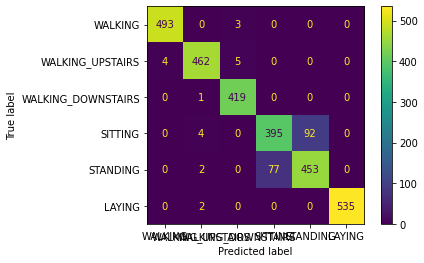

In [11]:
%time plot_confusion_matrix(rocket_pipeline, X_test, y_test, display_labels = LABELS)